<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/4_5_cross_entropy_loss%2C_NLL%2C_and_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

# Cross Entropy Loss

For classifying the MNIST dataset we will use the ["Cross Entropy" loss](https://en.wikipedia.org/wiki/Cross_entropy). This is the standard loss function when you want to compare a one-hot encoding to a ground truth label. Briefly, the Cross Entropy loss normalizes the 1-hot output vector using a [Soft Max](https://en.wikipedia.org/wiki/Softmax_function) normalization, then penalizes the normalized values vs. the ground based on the Negative Log Likelihood.

## Cross Entropy: Softmax
The role of SoftMax in our loss function is to convert the network output (10, 1-hot encoded values) into a probability distribution (10 values between 0 and 1, who sum to 1). This process could be done by normalizing the values directly by dividing them by the sum of the values. In contrast, SoftMax normalizes the exponential of each value rather than the direct values themselves. For example, SoftMax will turn a raw prediction of [2.0,0.5,0.0] into a normalized distribution of [0.7, 0.2, 0.1] (rather than [0.8, 0.2,0.0]).

Try the code below to see how softmax transforms a few different vectors:

In [ ]:
inputVal =  [0.0,0.0,0.0] #Try [1.0,0.0,-1.0] and [0.0, 0.0, 0.0], how would pure normalization handle these cases?

softMaxLayer = nn.Softmax(dim=1)
inputTensor = torch.tensor([inputVal])
outputValue = softMaxLayer(inputTensor)[0]

print(outputValue)

tensor([0.3333, 0.3333, 0.3333])


As compared to classical normalization (where you sum all the values and divide by the total), Softmax is more exaggerated given an extra bonus to the largest value. For example, Softmax will take the vector [4,3,0] and return [0.72, 0.27, 0.01] where classical normalization would result in [0.57,0.43,0]. Using softmax strongly encourages the network to focus on making sure the largest element is the correct one. Additionally, softmax supports negative inputs in a more natural way than classical normalization, and it does a better job of handling corner cases like [0,0,0] and [-1,0,1] (you should try some examples).

## Cross Entropy: Negative Log Likelihood (NLL)

The softmax will transform the raw network prediction to a distribution of how likely the network thinks each value is.  To compute a loss, we need to compare that distribution to the 1-hot encoded ground truth. The Negative Log Likelihood (NLL) loss penalizes a network based on the log of the ratio between the actual value and the predicted value: $\mathrm{NLL}(p) = \mathrm{log}(1/p_{true}) = -\mathrm{log}(p_{true})$, where $p$ is the distribution of probabilities predicted by the network and $p_{true}$ is the likelihood given to the ground truth label for the current input data. This formulation ensures that if the model predicts a value near $0$ for the true class the loss will be very high. As the model's  likelihood for the true class grows to $1$, the loss will go to $0$.

As an example, if the raw, unnormalized prediction from our model is [4,3,0], which the softmax turns into [0.72, 0.27, 0.01], and the true value is [1,0,0] (ie, the first class was the correct one) then the NLL loss is $\mathrm{log}(1/0.72) = -\mathrm{log}(0.72) = 0.14$. As this loss is pretty close to 0, that means the model is doing pretty good, but there is also clear room for improvement. The network could only have zero loss (that is, have no error) if it predicts 100\% chance for the ground truth label.

## Cross Entropy in PyTorch
PyTorch has a built in function to compute both steps of the Cross Entropy loss for us called `nn.CrossEntropyLoss()`. This will take in raw, unnormalized values and do both the Softmax step and the NLL computation for us. We call that here:

In [ ]:
loss_function = nn.CrossEntropyLoss()

**Note:** In practice, remember that unlike our simple example above, the PyTorch loss function operates on an entire batch of samples. While each sample in the batch will have its own individual loss, we want a single overall number to capture how well the model is doing. This process of going from a list of several numbers down a single number is called a reduction. By default PyTorch returns the average value over all the elements in the batch, which is often a good choice. We can change this behavior by setting the `reduction` parameter when we create a loss function.  For example:

In [ ]:
loss_function_sum = nn.CrossEntropyLoss(reduction='sum')

will take the sum of the loss of over all the samples in a batch (rather than the average). This can sometimes be useful if your batches are of different sizes from each other, as taking the mean value can obscure the differences in batch size.

# Classifying MNSIST

Ok, we can use Cross Entropy loss in practice to classify the MNIST Resutls into one of the 10 digits.

### Download the data

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

Train-test split

You should consider more complex cross-validation schemes, but for now, let's just do a single static split into testing and training data.

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

## Helper Function

We create some helper functions to plot the digits and show which predictions are correct.

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

We also can use some nice helper functions to train the model, track the loss, and graph results.

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

We also want a way to compute the accuracy of our model:

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #NEW: Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

We'll leverage the built-in `torch.utils.data.Dataset` class to help us associate training features and labels and to keep everything in tensors as PyTorch expects.

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

## Model

For now, let's continue using a simple linear model. Note, we extend PyTorch's built-in `nn.Module` class.

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

## Loading Data & 1-Hot Encoding

Ok, we have to do a bit of painful data reshaping. The MNIST data we downloaded stores the labels in a dataframe of type `Categorical`

In [ ]:
type(mnist_training_labels)

pandas.core.arrays.categorical.Categorical

We want that in a numpy array.

In [ ]:
mnist_training_labels.to_numpy()

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

But notice it's an array of strings. Lets turn the strings to ints which will be easier to work with.

In [ ]:
mnist_training_labels.to_numpy().astype(int)

array([5, 0, 4, ..., 5, 6, 8])

Ok, we have a numpy array of ints. But we need to store the resutls in a 1-hot encoding. That is, we want to convert each integert 0-9 into a vector where index 0-9 is a `1` and the rest of the vector is all `0`s.

Pytorch has a built-in function for this, but only if you pass it a tensor of long (64-bit) integers:

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int))

tensor([5., 0., 4.,  ..., 5., 6., 8.])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int)).long()

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

Ok, we can finally make our one-hot encoded category labels to use for training.

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()

And place these NumPy arrays in our Dataset class.

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)

## Training the Model

Loaded Data
Epoch [1/30], Train Loss: 4.5742, Test Loss: 2.5872
Epoch [6/30], Train Loss: 1.8667, Test Loss: 2.3279
Epoch [11/30], Train Loss: 1.6941, Test Loss: 1.8702
Epoch [16/30], Train Loss: 1.7923, Test Loss: 2.5232
Epoch [21/30], Train Loss: 1.6789, Test Loss: 2.3669
Epoch [26/30], Train Loss: 1.6929, Test Loss: 2.2698


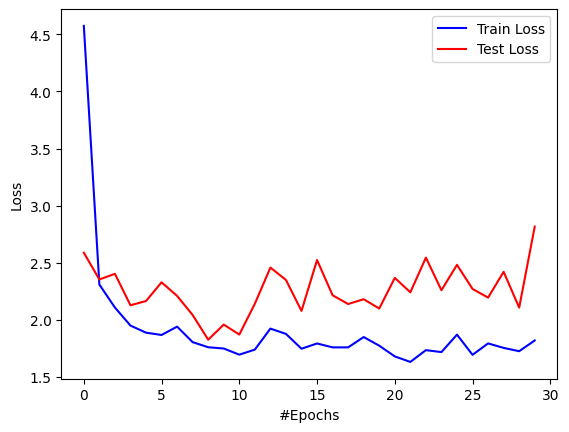

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 53391/60000 (89.0%)

Test Set: Accuracy: 8782/10000 (87.8%)


A confusion matrix allows us to see what classes are most/least often confused with another

Text(70.72222222222221, 0.5, 'Predicted Class')

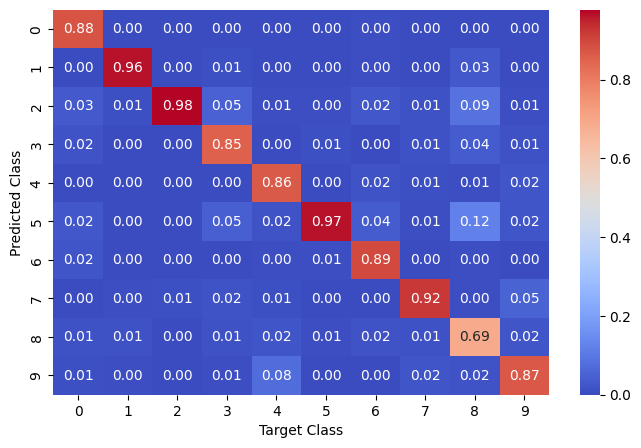

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "coolwarm") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

Note, the accuracy is good overall, but some numbers are more likely to be confused with other digits.

We can also look at some of the images with labels to get a better idea of where the failures are:

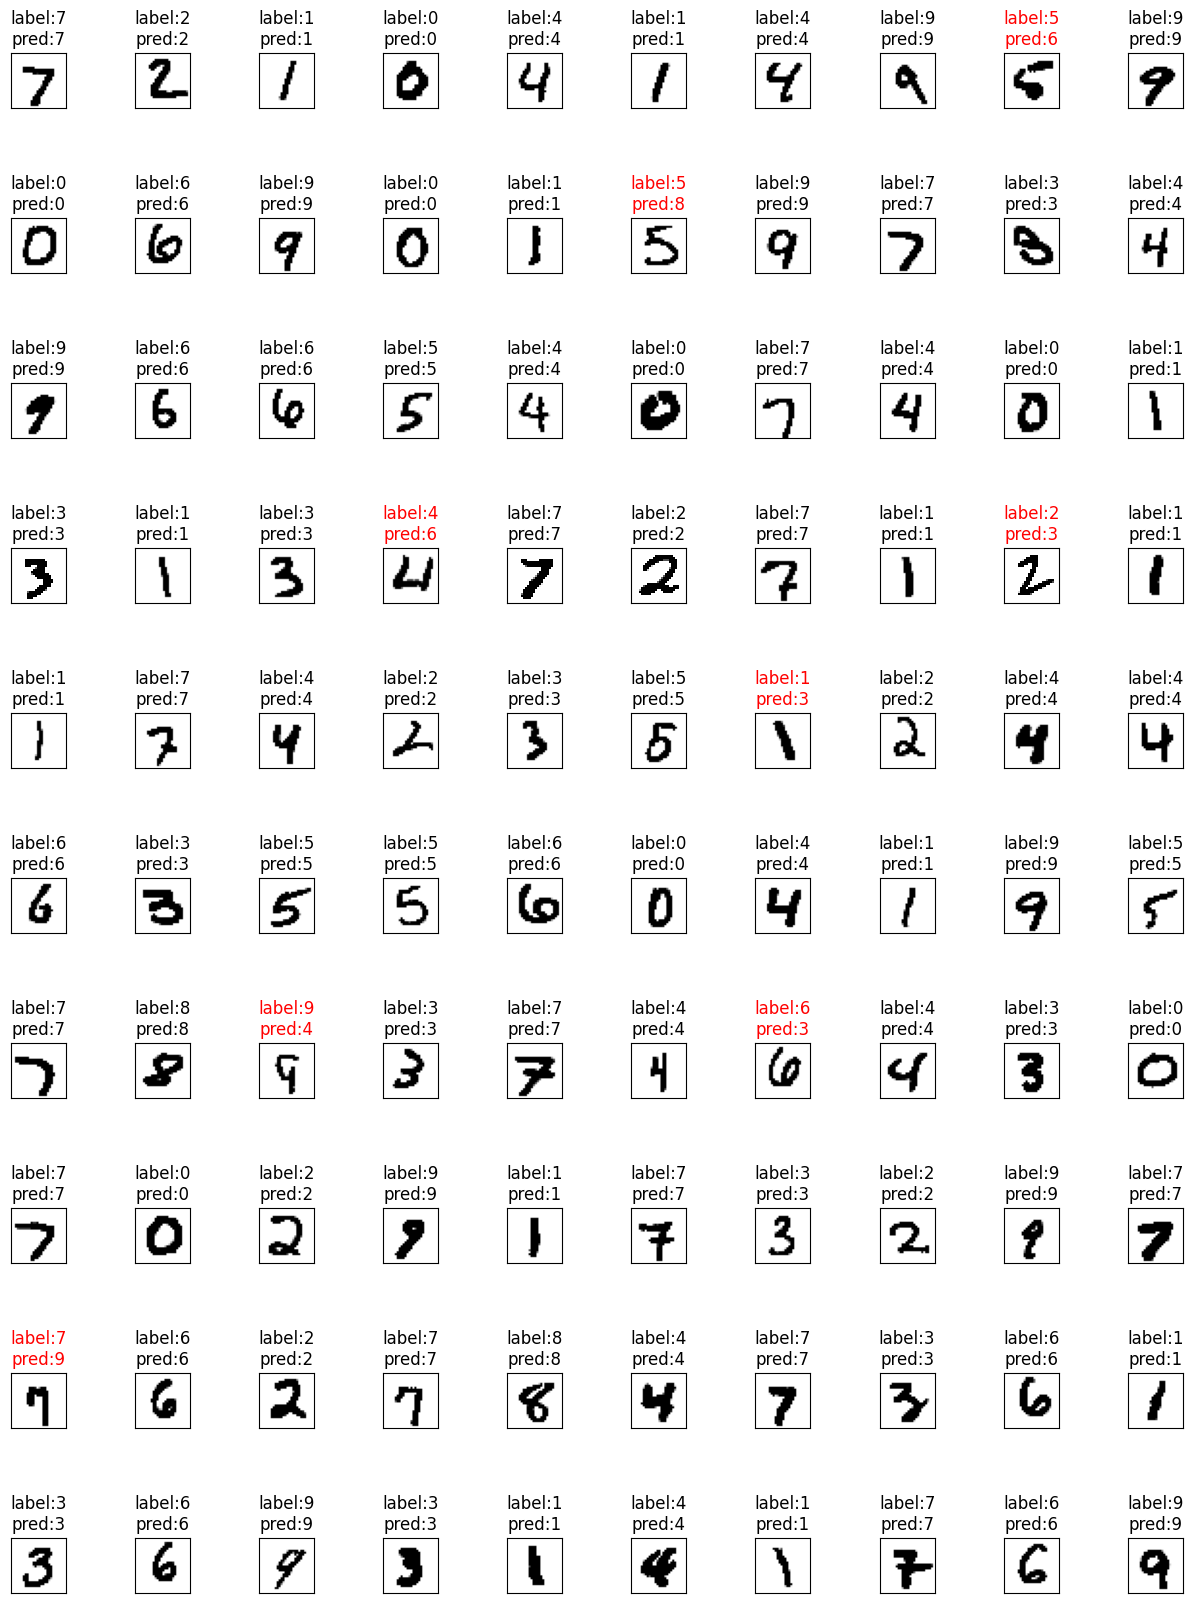

In [ ]:
plot_digits_with_mnist_predictions(model, mnist_testing_data, mnist_testing_labels_catigories)

## Multi-Layer Model

We can make the model more complex by adding linear tranformations, and adding some non-linear functions (such as `sin`, `cos`, or `relu`) between each linear layer.

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 1.0433, Test Loss: 0.3941
Epoch [6/30], Train Loss: 0.1727, Test Loss: 0.2060
Epoch [11/30], Train Loss: 0.1223, Test Loss: 0.1812
Epoch [16/30], Train Loss: 0.0996, Test Loss: 0.1678
Epoch [21/30], Train Loss: 0.0874, Test Loss: 0.1757
Epoch [26/30], Train Loss: 0.0773, Test Loss: 0.1694


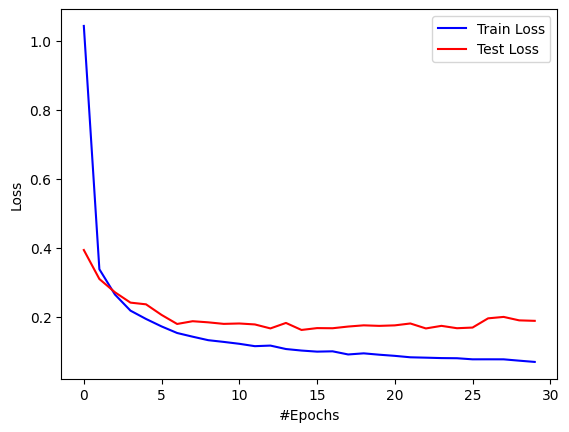

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Layers(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 58489/60000 (97.5%)

Test Set: Accuracy: 9516/10000 (95.2%)


Text(70.72222222222221, 0.5, 'Predicted Class')

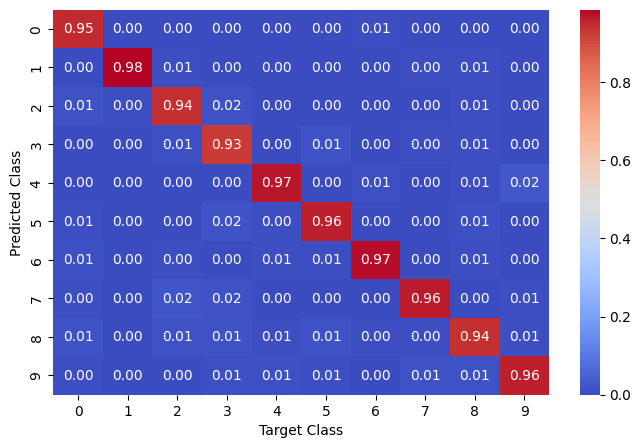

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "coolwarm") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

We see a drastic improvement in accuracy!

The few predctions that are wrong seems like easy mistakes to make such as confusing a `4` for a `9`.

Overall, the prediction visualization looks better too:

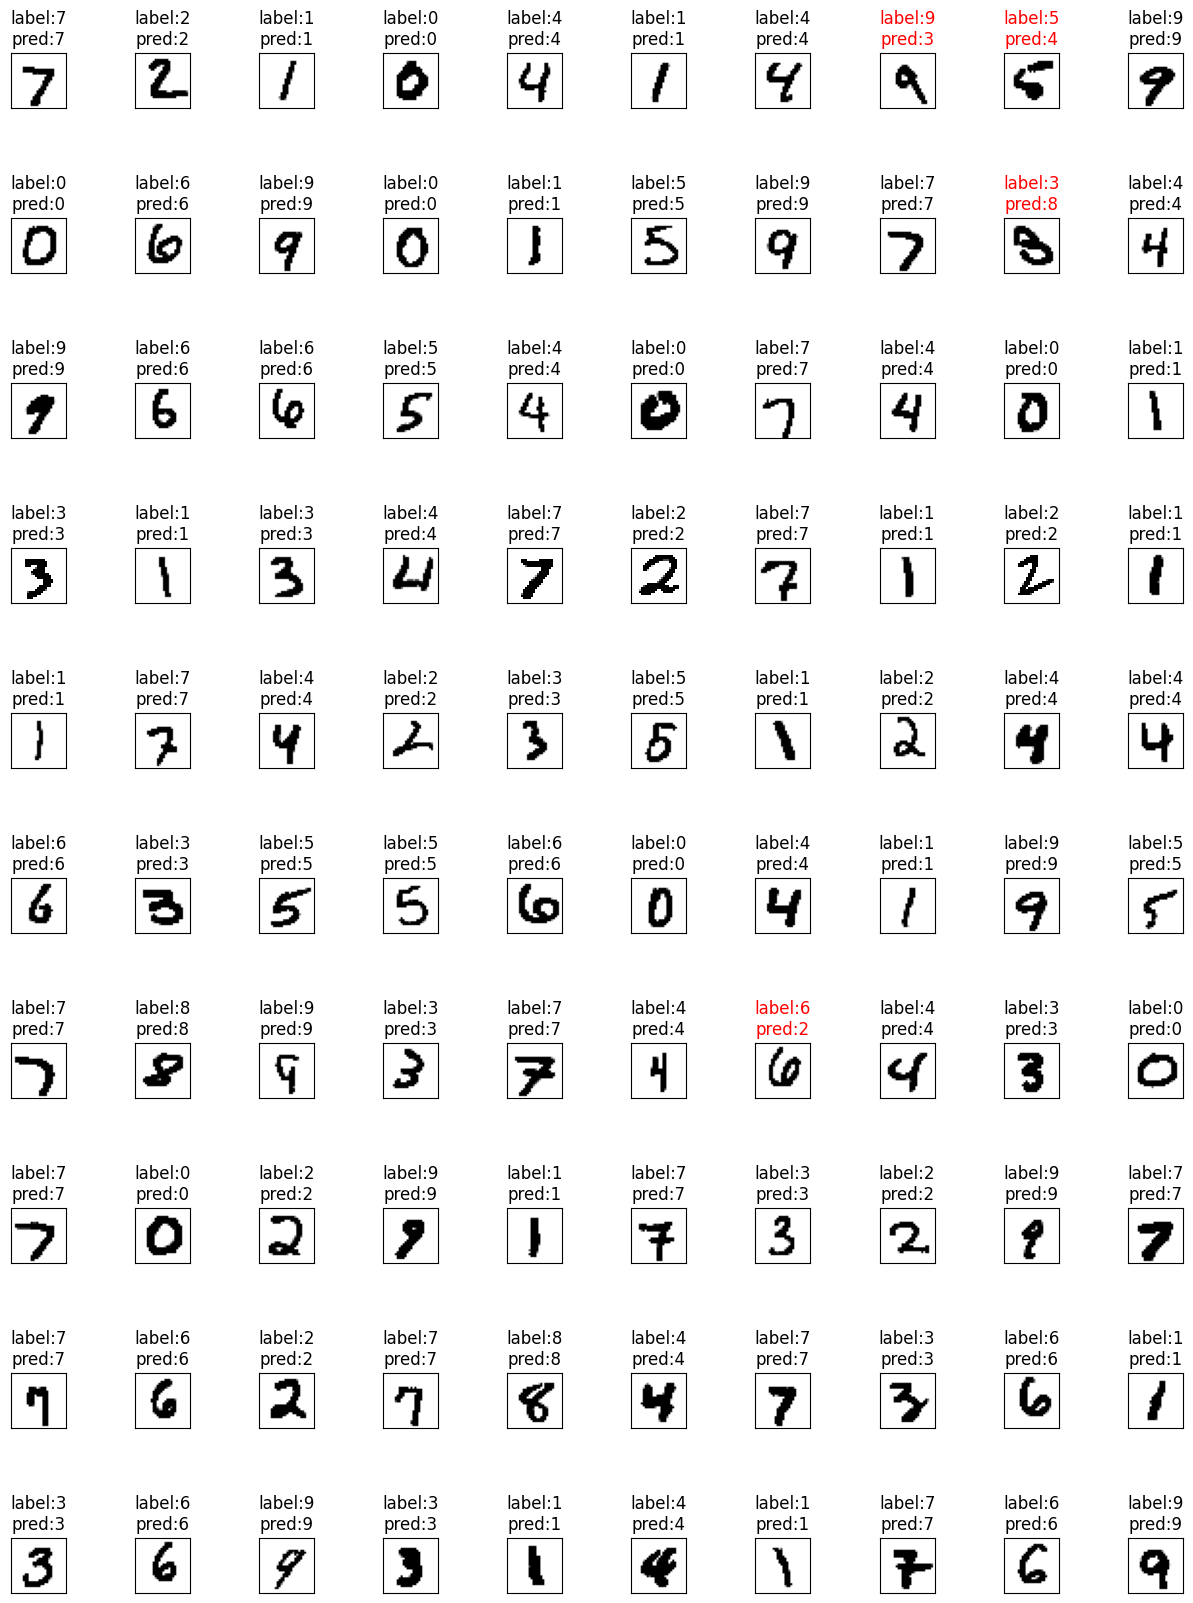

In [ ]:
plot_digits_with_mnist_predictions(model, mnist_testing_data, mnist_testing_labels_catigories)

---

Below you see a different 3-layer model called `Classifier_3Layers_bad`, I get 2-3x more error in the accuacy and loss as compared to `Classifier_3Layers`.
1. Run this the model to confirm the loss is higher and the accuracy is lower
2. Why is that? What is 'bad' about this model?
3. Can you solve this problem using the absolute value fuction (i.e. `torch.abs()`)

Submit your model accuracy and confusion matrix on Canvas!

In [ ]:
class Classifier_3Layers_bad(nn.Module):
    def __init__(self, img_w, img_h, numClasses):
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)      #Pytorch replaces -1 with  batch size
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

Loaded Data
Epoch [1/26], Train Loss: 1.4128, Test Loss: 0.5121
Epoch [6/26], Train Loss: 0.2934, Test Loss: 0.3104
Epoch [11/26], Train Loss: 0.2850, Test Loss: 0.3144
Epoch [16/26], Train Loss: 0.2802, Test Loss: 0.3170
Epoch [21/26], Train Loss: 0.2744, Test Loss: 0.3056
Epoch [26/26], Train Loss: 0.2675, Test Loss: 0.2920


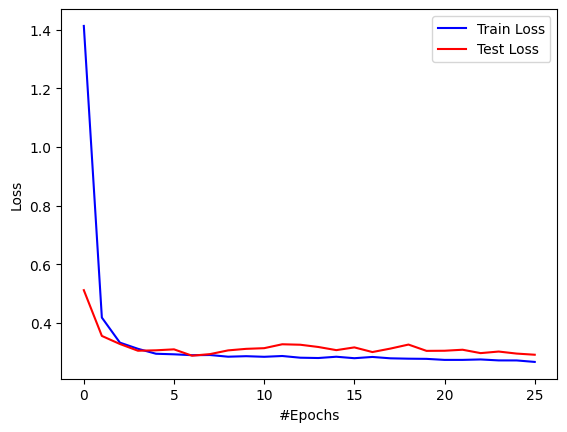

In [ ]:
#Training parameters
num_epochs = 26
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Layers_bad(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 55729/60000 (92.9%)

Train Set: Accuracy: 9196/10000 (92.0%)


Text(70.72222222222221, 0.5, 'Predicted Class')

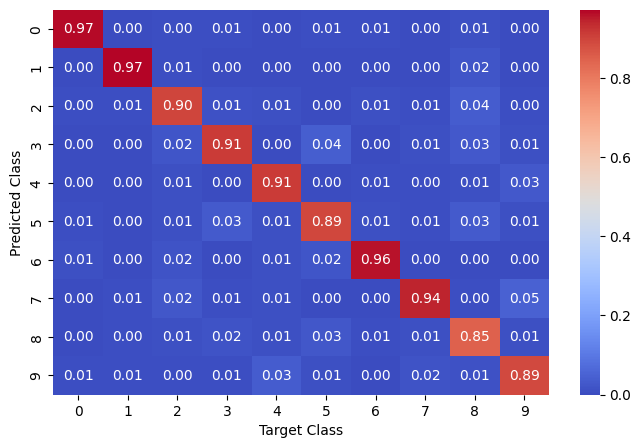

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "coolwarm") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")